##### Copyright 2025 Google LLC.

In [4]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: All about tokens

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Counting_Tokens.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

An understanding of tokens is central to using the Gemini API. This guide will provide a interactive introduction to what tokens are and how they are used in the Gemini API.

## About tokens

LLMs break up their input and produce their output at a granularity that is smaller than a word, but larger than a single character or code-point.

These **tokens** can be single characters, like `z`, or whole words, like `the`. Long words may be broken up into several tokens. The set of all tokens used by the model is called the vocabulary, and the process of breaking down text into tokens is called tokenization.

For Gemini models, a token is equivalent to about 4 characters. **100 tokens are about 60-80 English words**.

When billing is enabled, the price of a paid request is controlled by the [number of input and output tokens](https://ai.google.dev/pricing), so knowing how to count your tokens is important.


## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [5]:
%pip install -q -U "google-genai>=1.0.0"

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [6]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [7]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

## Tokens in the Gemini API

### Context windows

The models available through the Gemini API have context windows that are measured in tokens. These define how much input you can provide, and how much output the model can generate, and combined are referred to as the "context window". This information is available directly through [the API](https://ai.google.dev/api/rest/v1/models/get) and in the [models](https://ai.google.dev/models/gemini) documentation.

In this example you can see the `gemini-2.5-flash-preview-04-17` model has an 1M tokens context window. If you need more, Pro models have an even bigger 2M tokens context window.

In [8]:
MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}
model_info = client.models.get(model=MODEL_ID)

print("Context window:",model_info.input_token_limit, "tokens")
print("Max output window:",model_info.output_token_limit, "tokens")

Context window: 1048576 tokens
Max output window: 65536 tokens


## Counting tokens

The API provides an endpoint for counting the number of tokens in a request: [`client.models.count_tokens`](https://googleapis.github.io/python-genai/#count-tokens-and-compute-tokens). You pass the same arguments as you would to [`client.models.generate_content`](https://googleapis.github.io/python-genai/#generate-content) and the service will return the number of tokens in that request.

### Choose a model

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

The tokenization should be more or less the same for each of the Gemini models, but you can still switch between the different ones to double-check.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [9]:
MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

### Text tokens

In [10]:
response = client.models.count_tokens(
    model=MODEL_ID,
    contents="What's the highest mountain in Africa?",
)

print("Prompt tokens:",response.total_tokens)

Prompt tokens: 10


When you call `client.models.generate_content` (or `chat.send_message`) the response object has a `usage_metadata` attribute containing both the input and output token counts (`prompt_token_count` and `candidates_token_count`):

In [11]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="The quick brown fox jumps over the lazy dog."
)
print(response.text)

Okay, you've provided the sentence: "The quick brown fox jumps over the lazy dog."

That's a very famous sentence! It's commonly used because it's a **pangram**, meaning it contains every letter of the English alphabet.

Is there anything specific you'd like to do with this sentence? For example:

*   Analyze it?
*   Translate it?
*   Use it in a story?
*   Ask a question about it?


In [12]:
print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 11
Output tokens: 469
Total tokens: 480


### Multi-modal tokens

All input to the API is tokenized, including images or other non-text modalities.

Images are considered to be a fixed size, so they consume a fixed number of tokens, regardless of their display or file size.

Video and audio files are converted to tokens at a fixed per second rate.

The current rates and token sizes can be found on the [documentation](https://ai.google.dev/gemini-api/docs/tokens?lang=python#multimodal-tokens)

In [13]:
!curl -L https://goo.gle/instrument-img -o organ.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0    901      0 --:--:-- --:--:-- --:--:--   903
100  374k  100  374k    0     0   894k      0 --:--:-- --:--:-- --:--:--  894k


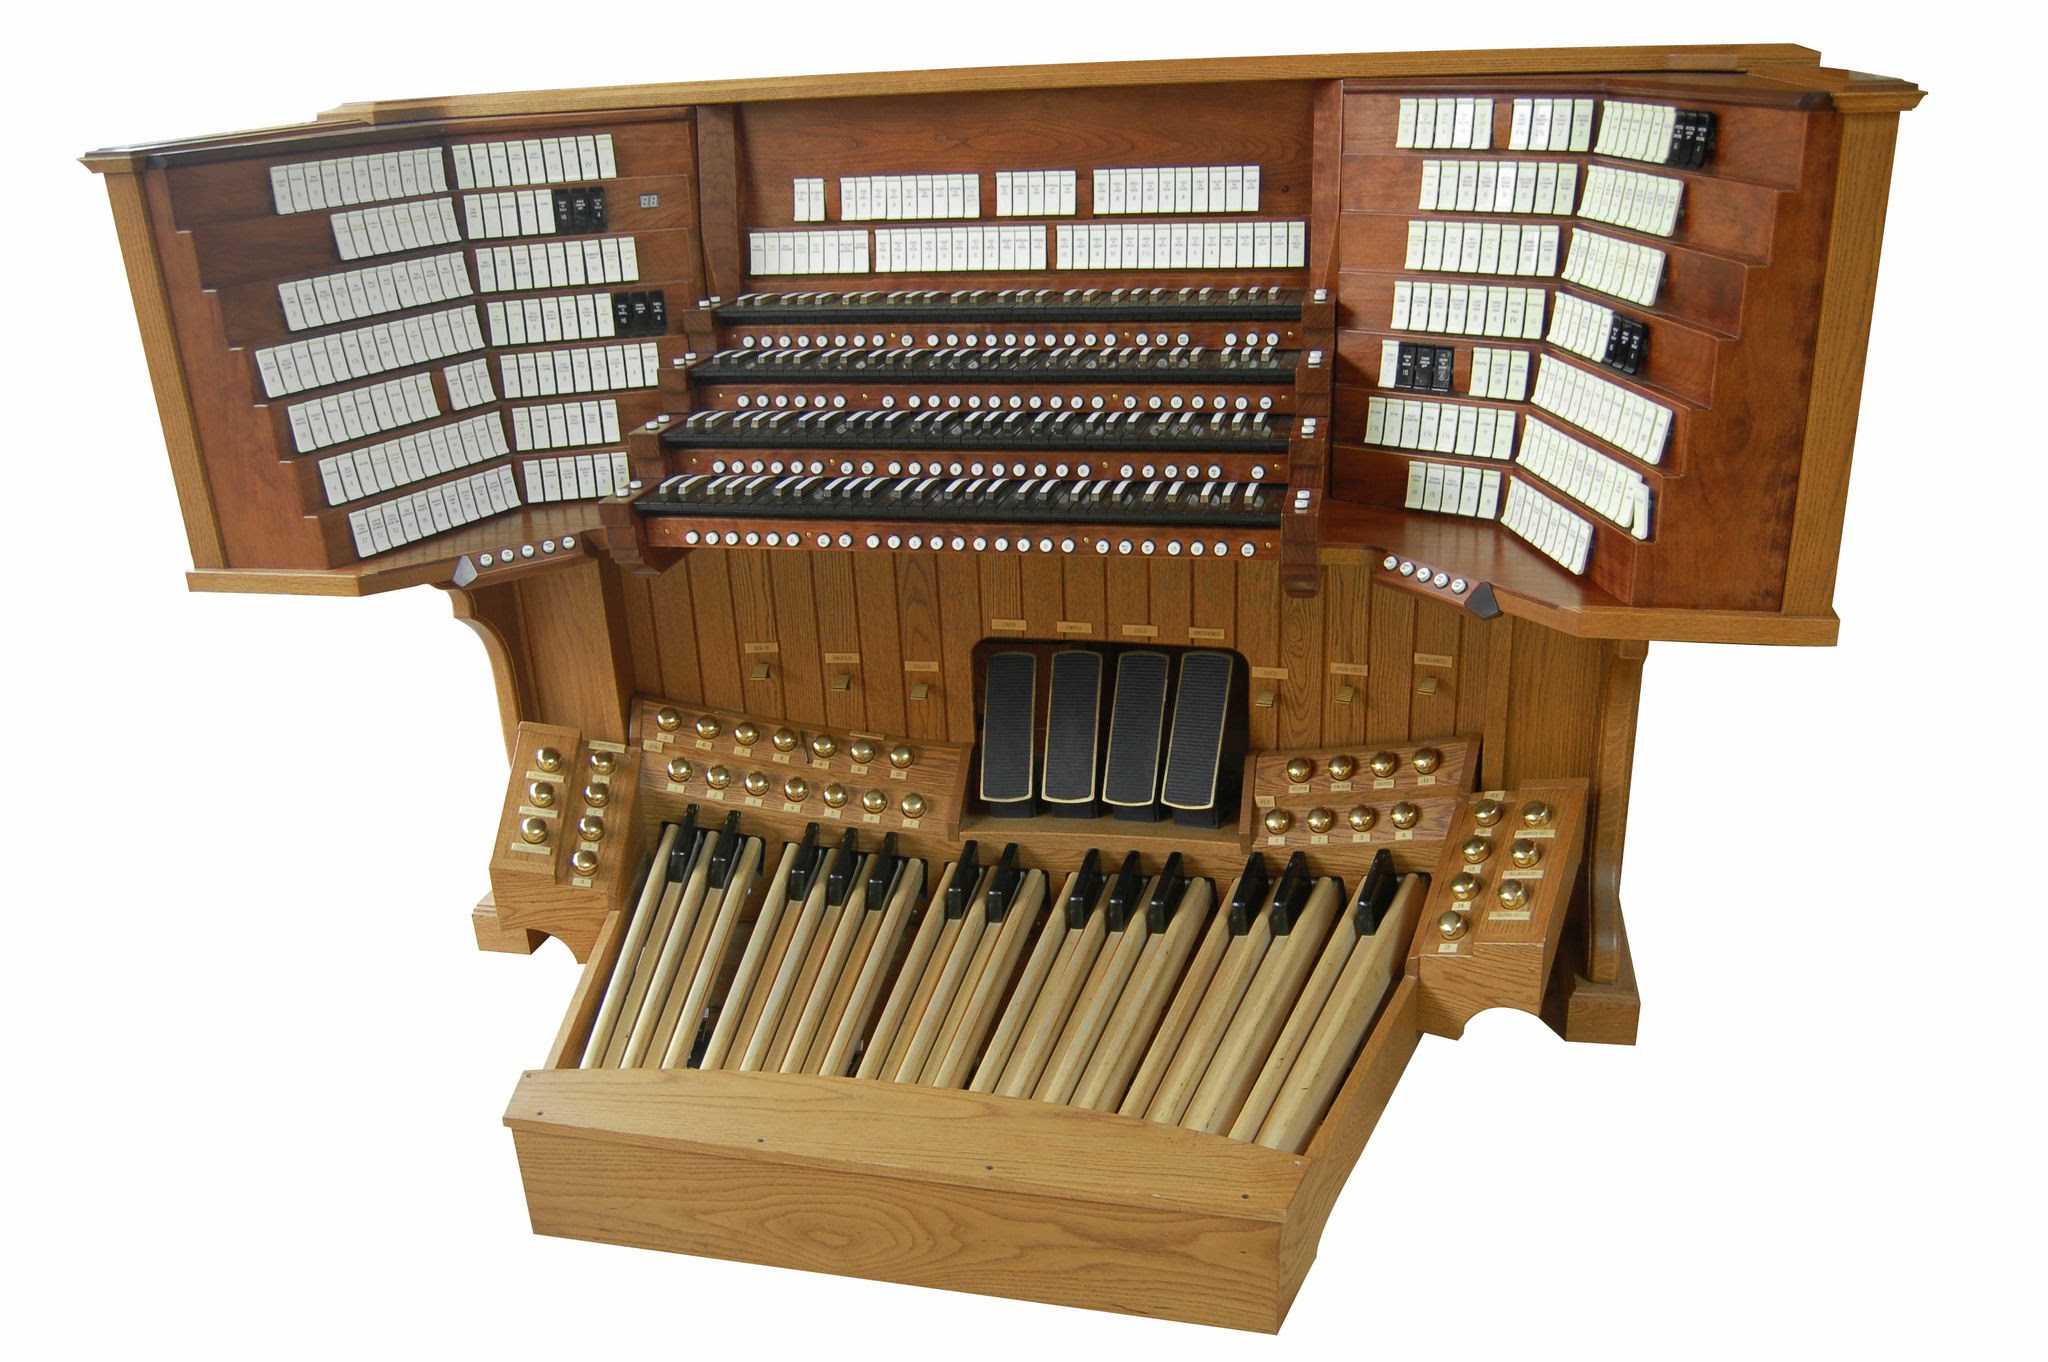

In [14]:
import PIL
from IPython.display import display, Image

organ = PIL.Image.open('organ.jpg')
display(Image('organ.jpg', width=300))

#### Inline content

Media objects can be sent to the API inline with the request:

In [15]:
response = client.models.count_tokens(
    model=MODEL_ID,
    contents=[organ]
)

print("Prompt with image tokens:",response.total_tokens)

Prompt with image tokens: 259


You can try with different images and should always get the same number of tokens, that is independent of their display or file size. Note that an extra token seems to be added, representing the empty prompt.

#### Files API

The model sees identical tokens if you upload parts of the prompt through the files API instead:

In [16]:
organ_upload = client.files.upload(file='organ.jpg')

response = client.models.count_tokens(
    model=MODEL_ID,
    contents=organ_upload,
)

print("Prompt with image tokens:",response.total_tokens)

Prompt with image tokens: 259


Audio and video are each converted to tokens at a fixed rate of tokens per minute.

In [17]:
!curl -q -o sample.mp3  "https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3"
!ffprobe -v error -show_entries format=duration sample.mp3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.8M  100 39.8M    0     0  27.7M      0  0:00:01  0:00:01 --:--:-- 27.7M
[FORMAT]
duration=2610.128938
[/FORMAT]


As you can see, this audio file is 2610s long.

In [18]:
audio_sample = client.files.upload(file='sample.mp3')

response = client.models.count_tokens(
    model=MODEL_ID,
    contents=audio_sample
)

print("Prompt with audio tokens:",response.total_tokens)
print("Tokens per second: ",response.total_tokens/2610)

Prompt with audio tokens: 83528
Tokens per second:  32.003065134099614


### Chat, tools and cache

Chat, tools and cache are currently not supported by the unified SDK `count_tokens` method. This notebook will be updated when that will be the case.

In the meantime you can still check the token used after the call using the `usage_metadata` from the response. Check the [caching notebook](./Caching.ipynb) for more details.

## Further reading

For more on token counting, check out the [documentation](https://ai.google.dev/gemini-api/docs/tokens?lang=python#multimodal-tokens) or the API reference:

* [`countTokens`](https://ai.google.dev/api/rest/v1/models/countTokens) REST API reference,
* [`count_tokens`](https://googleapis.github.io/python-genai/#count-tokens-and-compute-tokens) Python API reference,